# Depth Animations

In [43]:
%matplotlib inline
%matplotlib notebook

import fnmatch
import scipy.optimize as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from IPython.display import set_matplotlib_formats
from scipy.optimize import curve_fit
import re
import datetime as dt 
import scipy.signal

# %config InlineBackend.figure_formats = ['svg']
plt.rcParams['savefig.dpi'] = 350
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 1.

## Functions

In [44]:
def org_T_and_V(array,procZ):
    # obtain important array data
    lol = pd.DataFrame(array)
    lrow,lcol = lol.shape
    n = np.linspace(0,1,procZ+1)
    # prepare dictionary
    dates_list = [dt.datetime(2015,11,i+1) for i in range(procZ)]
    month_day_list = [d.strftime("%m%d") for d in dates_list]

    dataframe_collection = {} 
    i = 0

    for month_day in month_day_list:
        dataframe_collection[month_day] = lol.iloc[:,int(lcol*n[i]):int(lcol*(n[i+1]))].T.reset_index(drop=True).T
        i = i + 1
        
    Data = pd.concat(dataframe_collection.values(),ignore_index = True).reset_index(drop=True)
        
    for i in range(procZ-1):
        Data = Data.drop(Data.index[int((i+1)*(lrow-1))]).reset_index(drop=True)
      
    tempNumpy = Data.to_numpy()
    return tempNumpy

In [45]:
def profile_averages(Tarray,Varray,pts):
    Tave = np.mean(Tarray[:,pts::],axis=1)
    Vave = np.mean(Varray[:,pts::],axis=1)    
    return Tave,Vave

In [46]:
def compute_nua(meta, pts):
    nut=np.mean(meta[2,pts:])
    nub=np.mean(meta[3,pts:])
    return nut, nub

In [47]:
def get_short_inds(procZ,inds,Tarray):
    lrow,lcol = Tarray.shape
    inds2 = inds[inds<lcol]
    return inds2

In [48]:
def statSteadSate(y):
    y = pd.DataFrame(y)
    count1 = len(y)
    aveWindow = int(np.floor(count1/3))
    varWindow = int(np.floor(count1/10))
    rolave = y.rolling(window=aveWindow,min_periods=varWindow).mean()
    rolstd = y.rolling(window=aveWindow,min_periods=varWindow).std()
    rolstd2 = (rolstd-np.min(rolstd))/(np.max(rolstd)-np.min(rolstd)) #normalize
    d = rolstd*100/rolave
    dlen = len(d)
    dave = np.mean(d[0:int(np.floor(dlen/3))])
    idxs = np.where(rolstd2<0.05)
    idx = idxs[0][0]
    return idx

In [49]:
def rmsValue(arr):
    n = len(arr)
    square = 0
    mean = 0.0
    root = 0.0     
    #Calculate square
    for i in range(0,n):
        square += (arr[i]**2)     
    #Calculate Mean
    mean = (square / (float)(n))     
    #Calculate Root
    root = np.sqrt(mean)     
    return root

In [50]:
def profile_averages(Tarray,Varray,pts):
    Tave = np.mean(Tarray[:,pts::],axis=1)
    Vave = np.mean(Varray[:,pts::],axis=1)    
    return Tave,Vave

def compute_nua(meta, pts):
    nut=np.mean(meta[2,pts:])
    nub=np.mean(meta[3,pts:])
    return nut, nub

def get_short_inds(procZ,inds,Tarray):
    lrow,lcol = Tarray.shape
    inds2 = inds[inds<lcol]
    return inds2

def statSteadSate(y):
    y = pd.DataFrame(y)
    count1 = len(y)
    aveWindow = int(np.floor(count1/3))
    varWindow = int(np.floor(count1/10))
    rolave = y.rolling(window=aveWindow,min_periods=varWindow).mean()
    rolstd = y.rolling(window=aveWindow,min_periods=varWindow).std()
    rolstd2 = (rolstd-rolstd.min())/(rolstd.max()-rolstd.min()) #normalize
    d = rolstd*100/rolave
    dlen = len(d)
    dave = d[0:int(np.floor(dlen/3))].mean()
    idxs = np.where(rolstd2<0.05)
    idx = idxs[0][0]
    return idx

def rmsValue(arr):
    n = len(arr)
    square = 0
    mean = 0.0
    root = 0.0     
    #Calculate square
    for i in range(0,n):
        square += (arr[i]**2)     
    #Calculate Mean
    mean = (square / (float)(n))     
    #Calculate Root
    root = np.sqrt(mean)     
    return root

## Process output data

### Load Data 

In [51]:
res = '256'; ra = '1e8'; modelType = 'ISO';
modelName1= modelType+'Ra'+ra;
model_name=modelName1+'-'+res # just your model name
big_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions\\'
# big_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL-multiple\\'

model_path_prefix2=big_path + ra  # adjust for where the model data is located
model_path_prefix=big_path + ra + '\\' + res +'\\Case' \
        + model_name+'\\output-'+model_name
full_path = big_path + ra + '\\' + res

nu_path = big_path + ra

pts=[]

meta = np.genfromtxt(model_path_prefix+'.meta.ave.dat')
temp = np.genfromtxt(model_path_prefix+'.temp.ave.dat')
vrms = np.genfromtxt(model_path_prefix+'.vrms.ave.dat')
z = np.genfromtxt(model_path_prefix2 + '\\'+res+'\\Case'+ model_name+'\\globalz.txt')

### Find Z number

Find the number of processors in input file in order to organize the data

In [52]:
with open(model_path_prefix2 + '\\'+res+'\\input.'+modelName1+res,"r") as fi:
    strProcZ = []
    for ln in fi:
        if ln.startswith('	nprocz'):
            strProcZ.append(ln.split(' ', 2)[0].split('=',1)[1].split('\t',3)[0])
procZ = int(strProcZ[0])
print('The number of processors in the Z direction is',procZ)

The number of processors in the Z direction is 4


### Organize Data:
#### Nusselt Number

<IPython.core.display.Javascript object>


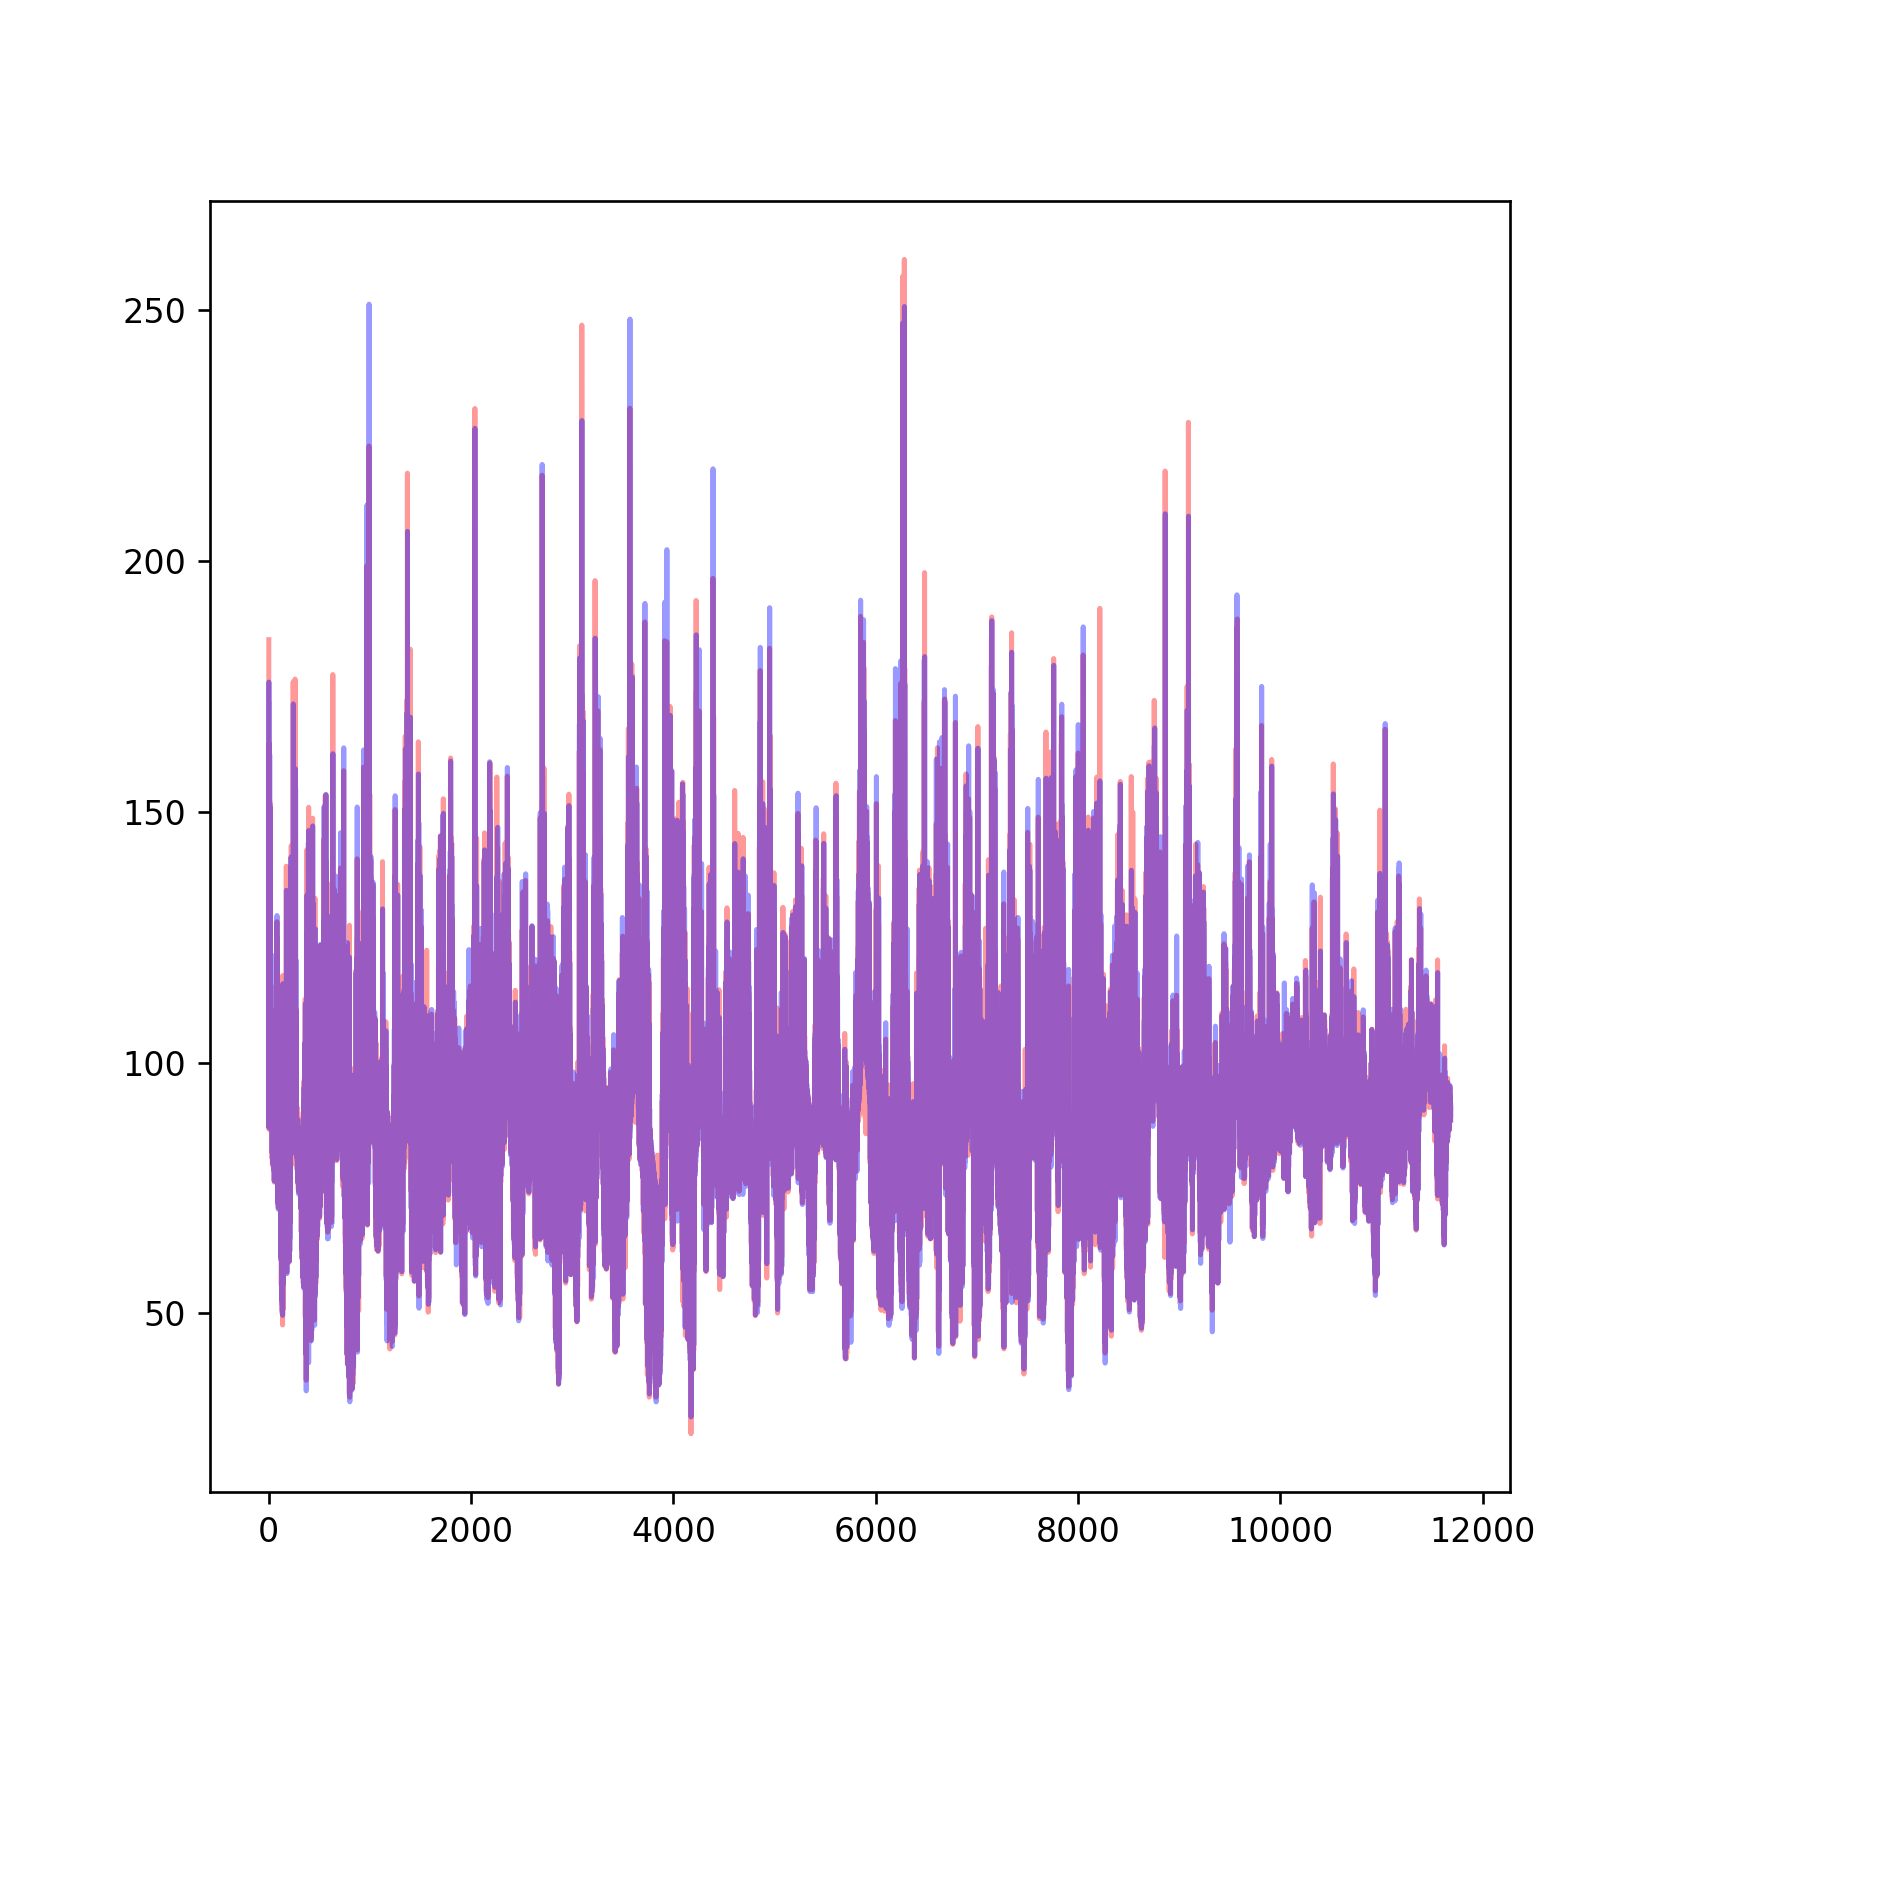

In [53]:
inds = np.argsort(meta[0,:],kind='stable')
meta = meta[:,inds]
lenNu = len(meta[2,:])
if meta[2,int(lenNu/2)]/np.max(meta[2,:]) < 1e-2:
    meta = meta[:,int(lenNu/20):]
plt.figure()
plt.plot(meta[2,:],color='red',alpha=0.4);
plt.plot(meta[3,:], color='blue',alpha=0.4);
# plt.ylim((0,1000))

#### Temperature and RMS Velocity

In [54]:
Tarray2 = org_T_and_V(temp,procZ)
Varray2 = org_T_and_V(vrms,procZ)

inds2 = get_short_inds(procZ,inds,Tarray2)

Tarray=Tarray2[:,inds2]
Varray=Varray2[:,inds2]

### Find Statistical Steady State Point and Nusselt Value

The Statistical Steady State Point is 11576

The Nusselt Number at the Top is 85.097
The Nusselt Number at the Bottom is 85.242


<IPython.core.display.Javascript object>


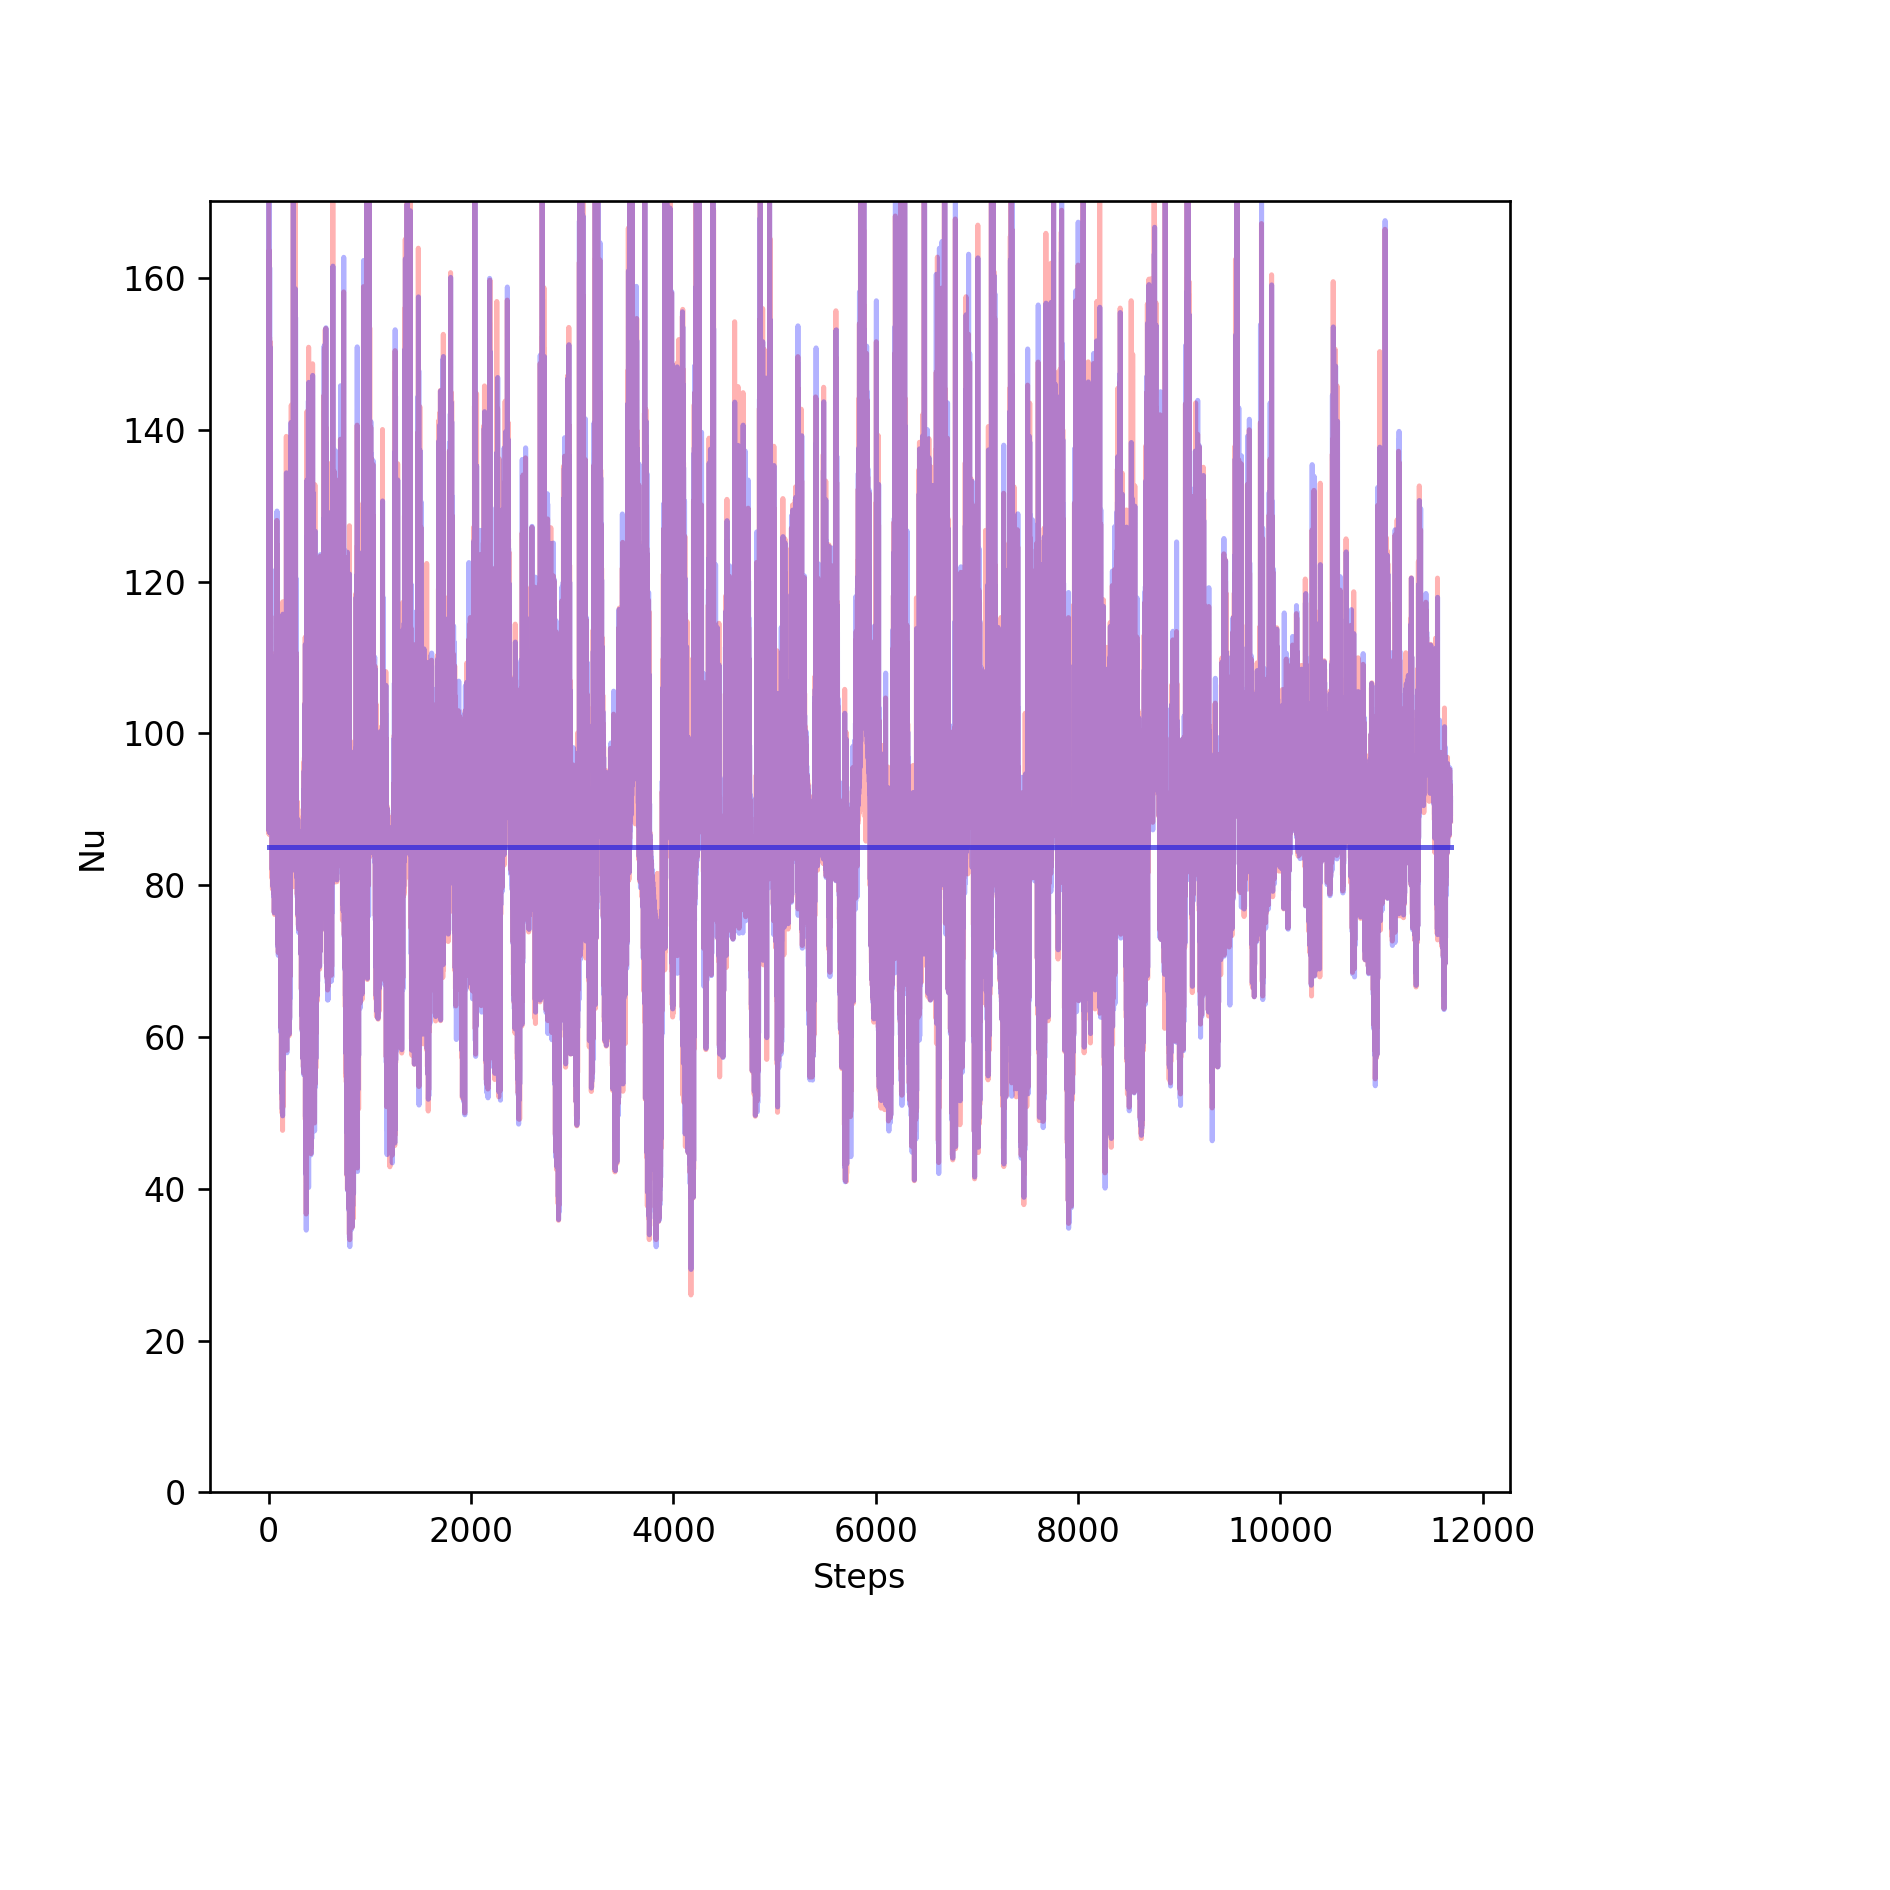

In [55]:
pts1 = statSteadSate(meta[2,:])
pts2 = statSteadSate(meta[3,:])
pts = np.max((pts1,pts2))
print('The Statistical Steady State Point is',pts)
print()
# pts = [1000]
nut,nub = compute_nua(meta,pts)
print('The Nusselt Number at the Top is',round(nut,3))
print('The Nusselt Number at the Bottom is',round(nub,3))

plt.figure()
plt.plot(meta[2,:],color='red', alpha=0.3);
plt.plot(meta[3,:], color='blue', alpha=0.3);
xx = np.linspace(0,len(meta[0,:]),10)
plt.plot(xx,0*xx+nut,color='#2421de', alpha=0.7);
plt.ylim((nut-nut,nut+nut));

plt.ylabel('Nu')
plt.xlabel('Steps');

### Get Profile Averages

The Statistical Steady State Point is 721


<IPython.core.display.Javascript object>


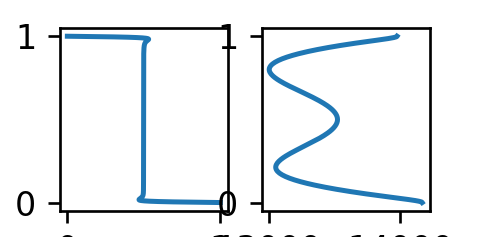

13433.219965870452


In [56]:
v_rms = rmsValue(Varray)
pts = statSteadSate(v_rms)
print('The Statistical Steady State Point is',pts)
Tave,Vave = profile_averages(Tarray,Varray,pts)
final_V_rms = np.mean(v_rms[pts:])

fig = plt.figure(figsize=(2,1))

ax1 = plt.subplot(121)
plt.plot(Tave,z)
ax1.set_ylabel('Radius')
ax1.set_xlabel('Temperature')

ax2 = plt.subplot(122)
plt.plot(Vave,z)
ax2.set_xlabel('Velocity');
print(final_V_rms)

<IPython.core.display.Javascript object>


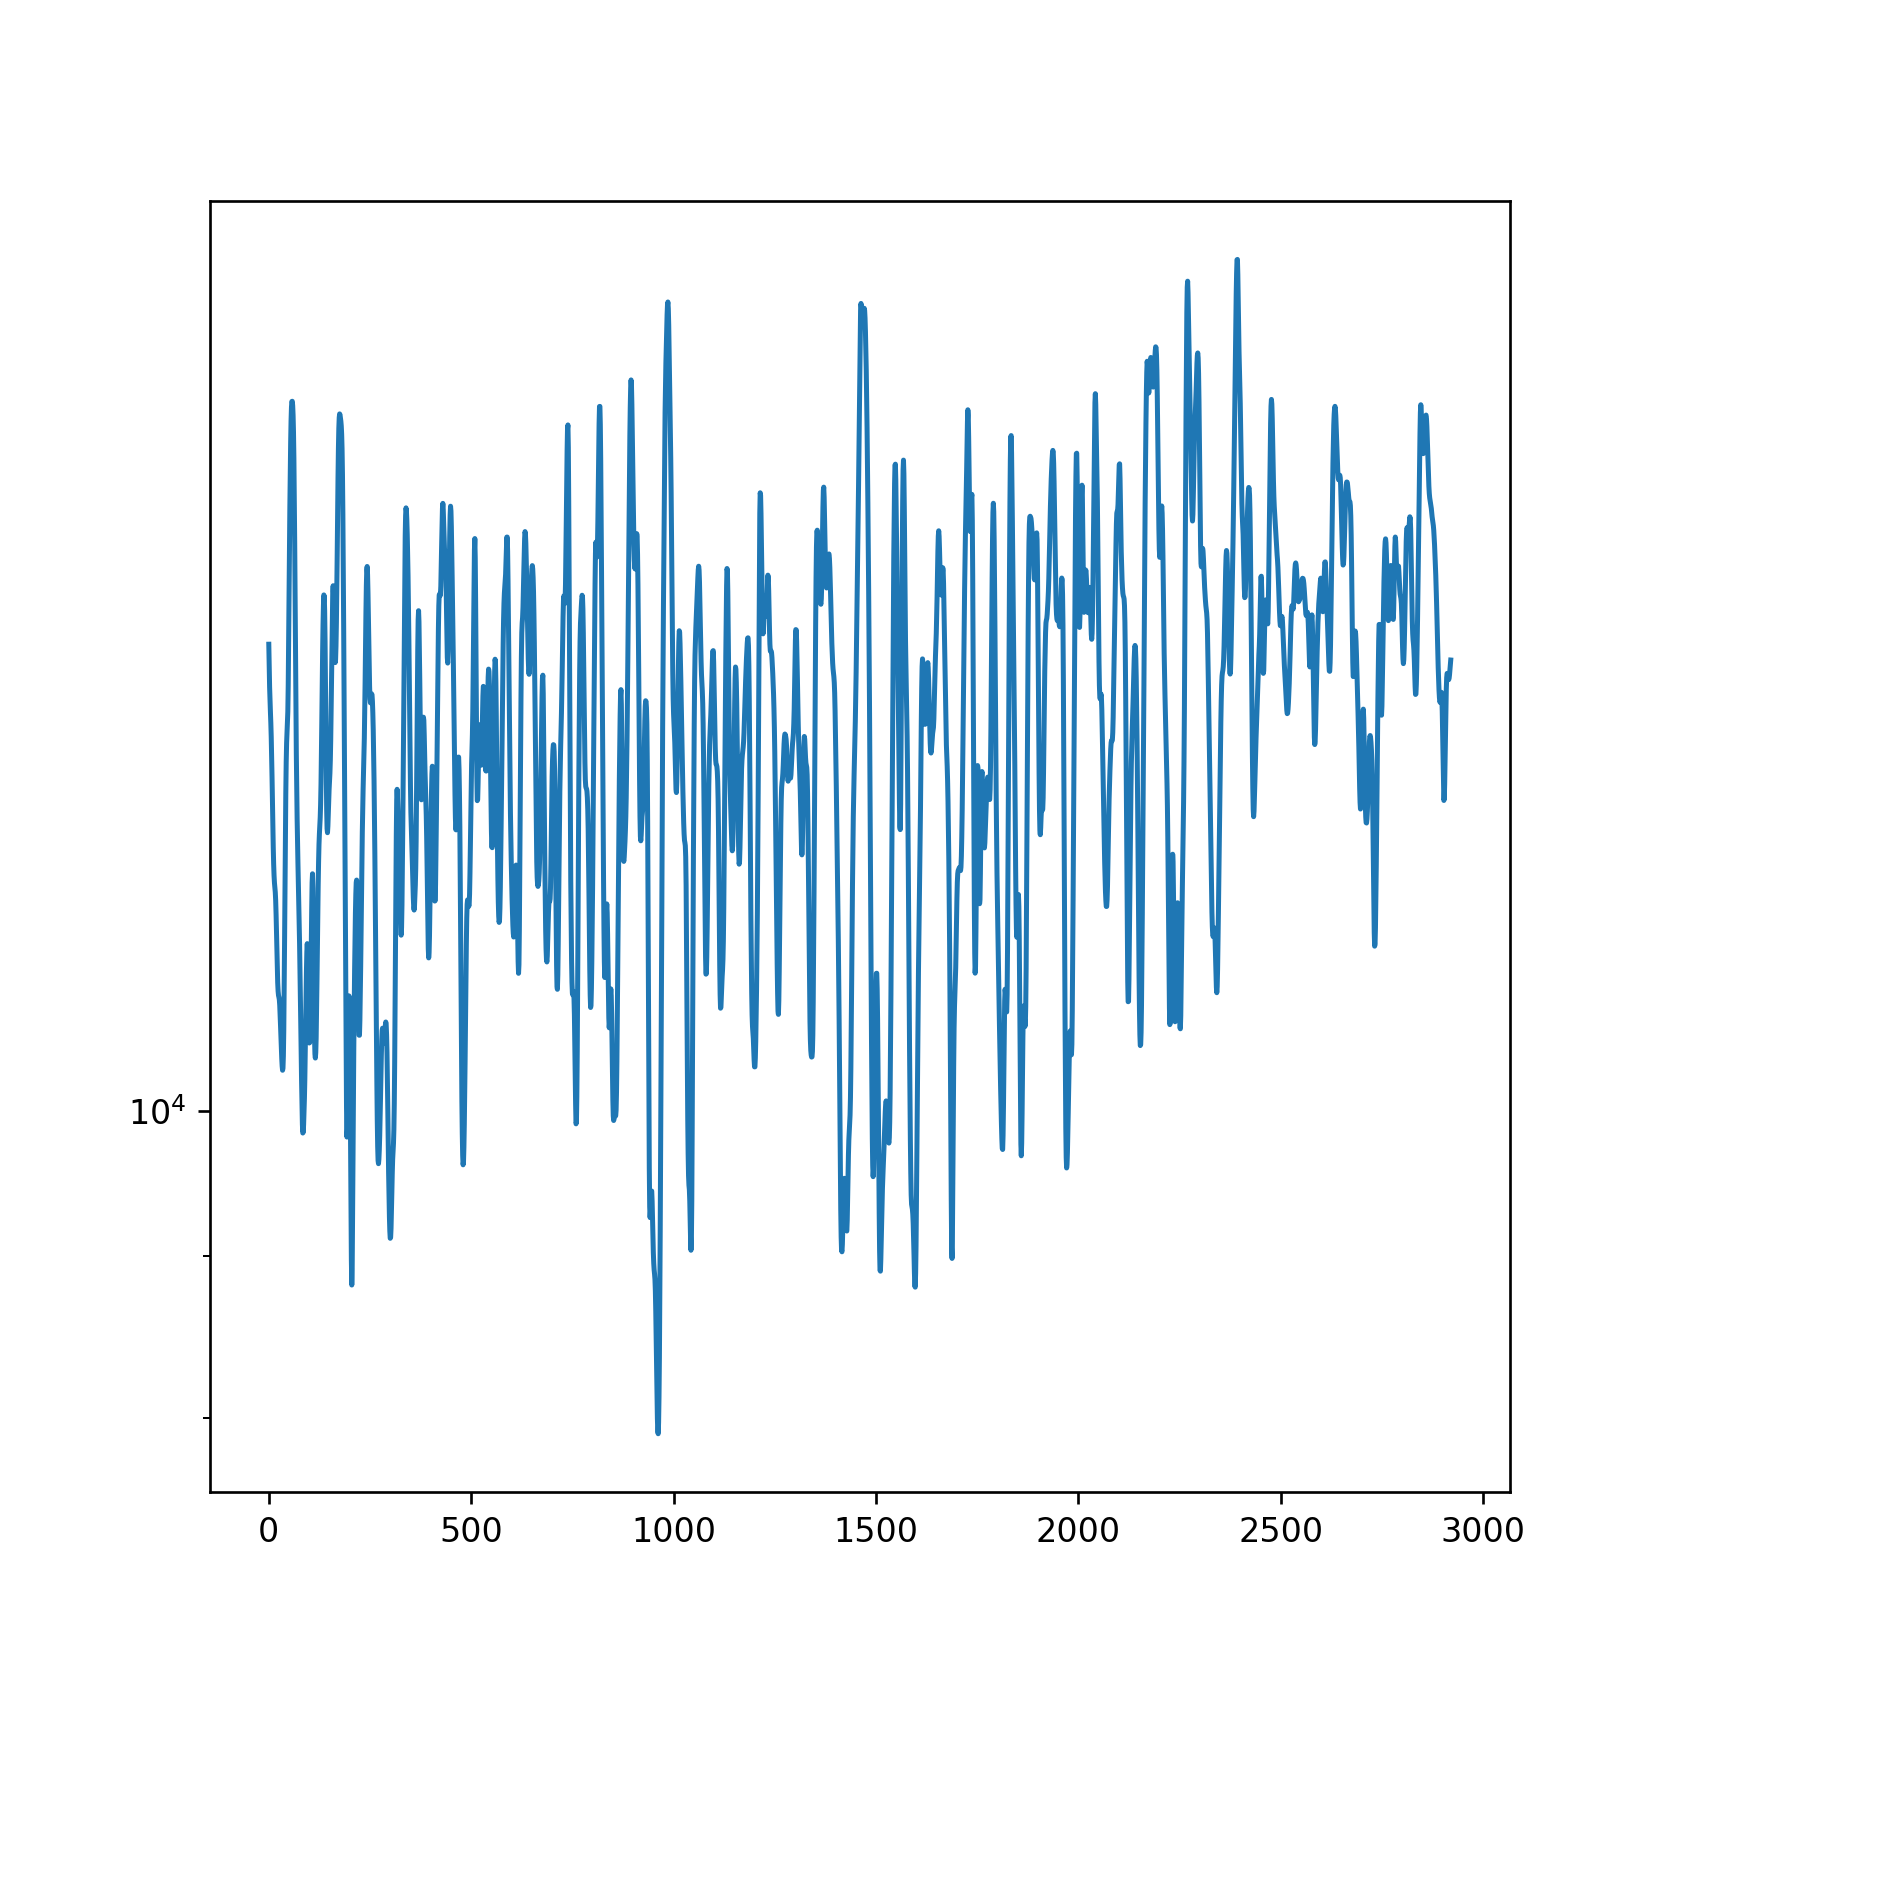

In [57]:
fig = plt.figure()
plt.plot(v_rms)
plt.yscale('log');

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Generate some example data
# data = np.random.rand(257, 2921)
data = Tarray[:,int(pts/5):]

# Set up the plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
title = ax.set_title('')

# Define the initialization function for the animation
def init():
    line.set_data([], [])
    ax.set_ylim(0, 1)
    ax.set_xlim(np.min(data), np.max(data))
    title.set_text('')
    return line, title

# Define the update function for the animation
def update(frame):
    y = data[:, frame]
    line.set_data(y,z)
    title.set_text('Time Step: {}'.format(frame))
    if frame == data.shape[1] - 1:
        ani.event_source.stop()
    return line, title

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=data.shape[1], init_func=init, interval=50, blit=True)

fig.set_size_inches(1, 1)

# Display the animation
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


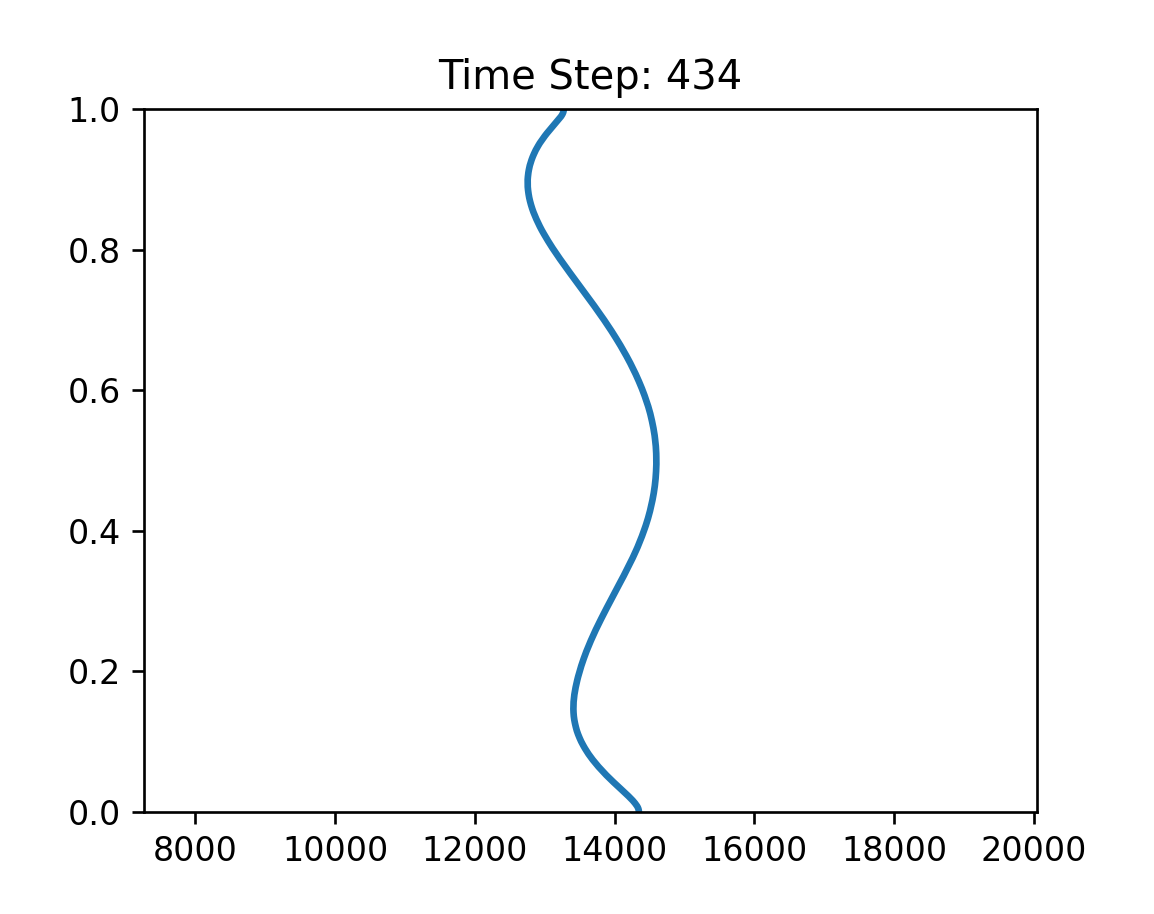

In [59]:
## import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Generate some example data
# data = np.random.rand(257, 2921)
data = Varray[:,int(pts/5):]

# Set up the plot
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
title = ax.set_title('')

# Define the initialization function for the animation
def init():
    line.set_data([], [])
    ax.set_ylim(0, 1)
    ax.set_xlim(np.min(data), np.max(data))
    title.set_text('')
    return line, title

# Define the update function for the animation
def update(frame):
    y = data[:, frame]
    line.set_data(y,z)
    title.set_text('Time Step: {}'.format(frame))
    if frame == data.shape[1] - 1:
        ani.event_source.stop()
    return line, title

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=data.shape[1], init_func=init, interval=10, blit=True)

fig.set_size_inches(1,1)

# Display the animation
plt.show()

In [60]:
Tarray.shape

(257, 2921)

In [61]:
Varray.shape

(257, 2921)